# Multi-Model Prediction Results Visualization and Analysis

This Notebook is used to visualize and analyze prediction results from multiple models on ICD-10 disease classification tasks.

## Objectives
- Compare prediction results and ground truth label distributions across multiple models
- Analyze model prediction accuracy and bias
- Generate detailed visualization reports
- Focus on 11 specific disease major categories

## Data Sources
- JSON format model prediction result files
- Contains ground truth labels and model prediction results
- Limited to 11 allowed disease categories: F32, F41, F39, F51, F98, F42, F31, F43, F45, F20, Z71


In [1]:
# 1. 导入必要的库
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Optional, Union
import warnings
import re
from datetime import datetime

# 忽略警告
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# 设置seaborn样式
sns.set_style("whitegrid")
sns.set_palette("husl")

print("✅ 库导入完成！")


✅ 库导入完成！


In [7]:
# 2. Configuration and ICD-10 Major Category Mapping

# Configure data paths
RESULTS_DIR = Path("results/MiroDiag-16K/results")
DATA_DIR = Path("./data")

# Allowed disease categories (only analyze these diseases)
ALLOWED_DISEASES = {'F32', 'F41', 'F39', 'F51', 'F98', 'F42', 'F31', 'F43', 'F45', 'F20', 'Z71'}

# ICD-10 major category code to English disease name mapping
ICD10_MAJOR_MAPPING = {
    'F32': 'Depressive Episode',
    'F41': ' Anxiety Disorders',
    'F39': 'Unspecified Mood Disorder',
    'F51': 'Nonorganic Sleep Disorders',
    'F42': 'Obsessive-Compulsive Disorder',
    'F31': 'Bipolar Affective Disorder',
    'F43': 'Stress-related disorders',
    'F45': 'Somatoform Disorders',
    'F20': 'Schizophrenia',
    'F98': ' Behavioral and Emotional Disorders',
    'Z71': 'Counseling and Medical Advice'
}

def extract_major_category(icd_code: str) -> str:
    """Extract ICD-10 major category (e.g., F32.900 -> F32)"""
    if not icd_code:
        return icd_code
    
    # Handle common formats
    if '.' in icd_code:
        return icd_code.split('.')[0]  # F32.900 -> F32
    elif len(icd_code) >= 3:
        return icd_code[:3]  # F32900 -> F32
    else:
        return icd_code

def get_major_disease_name(major_code: str) -> str:
    """Get English disease name for ICD-10 major category code"""
    return ICD10_MAJOR_MAPPING.get(major_code, major_code)

def filter_allowed_diseases(label_lists: List[List[str]]) -> List[List[str]]:
    """Keep only allowed disease categories"""
    filtered_lists = []
    for labels in label_lists:
        filtered_labels = [label for label in labels if label in ALLOWED_DISEASES]
        filtered_lists.append(filtered_labels)
    return filtered_lists

def convert_to_major_categories(label_lists: List[List[str]]) -> List[List[str]]:
    """Convert detailed ICD-10 codes to major categories and keep only allowed diseases"""
    major_label_lists = []
    for labels in label_lists:
        # Convert to major categories
        major_labels = [extract_major_category(label) for label in labels]
        # Keep only allowed disease categories
        filtered_major_labels = list(set([label for label in major_labels if label in ALLOWED_DISEASES]))
        major_label_lists.append(filtered_major_labels)
    return major_label_lists

# Import evaluation function from main file
def extract_and_filter_major_codes(codes_list):
    """Extract major codes from code list and filter to 11 allowed diseases (from main file)"""
    import re
    major_codes = []
    if not isinstance(codes_list, list):
        if pd.isna(codes_list) or codes_list is None:
            codes_list = []
        else:
            codes_list = [codes_list]
    
    for code in codes_list:
        if pd.isna(code) or code is None:
            continue
        code_str = str(code).strip()
        # Match F-prefix or Z71 major category codes
        major_match = re.match(r'(F\d+|Z71)', code_str)
        if major_match:
            major_code = major_match.group(1)
            # Keep only 11 allowed diseases
            if major_code in ALLOWED_DISEASES and major_code not in major_codes:
                major_codes.append(major_code)
    return major_codes

print("✅ Configuration completed!")
print(f"Results directory: {RESULTS_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Allowed disease categories: {sorted(ALLOWED_DISEASES)}")
print(f"ICD-10 major mapping entries: {len(ICD10_MAJOR_MAPPING)}")

# Display allowed diseases and their English names
print(f"\n📋 Disease categories for analysis:")
for disease_code in sorted(ALLOWED_DISEASES):
    disease_name = get_major_disease_name(disease_code)
    print(f"  {disease_code}: {disease_name}")


✅ Configuration completed!
Results directory: results/MiroDiag-16K/results
Data directory: data
Allowed disease categories: ['F20', 'F31', 'F32', 'F39', 'F41', 'F42', 'F43', 'F45', 'F51', 'F98', 'Z71']
ICD-10 major mapping entries: 11

📋 Disease categories for analysis:
  F20: Schizophrenia
  F31: Bipolar Affective Disorder
  F32: Depressive Episode
  F39: Unspecified Mood Disorder
  F41:  Anxiety Disorders
  F42: Obsessive-Compulsive Disorder
  F43: Stress-related disorders
  F45: Somatoform Disorders
  F51: Nonorganic Sleep Disorders
  F98:  Behavioral and Emotional Disorders
  Z71: Counseling and Medical Advice


In [8]:
# 3. 从最新Excel文件加载已处理的结果数据

def get_latest_excel_file() -> Optional[Path]:
    """获取最新的模型评估结果Excel文件"""
    excel_files = list(Path(".").glob("model_evaluation_results_*.xlsx"))
    
    if not excel_files:
        print("❌ 未找到Excel结果文件")
        return None
    
    # 按文件修改时间排序，选择最新的
    latest_file = max(excel_files, key=lambda x: x.stat().st_mtime)
    print(f"📁 找到最新Excel文件: {latest_file.name}")
    
    return latest_file

def load_excel_results(excel_file: Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """从Excel文件加载模型评估结果"""
    try:
        # 读取两个sheet
        detailed_results = pd.read_excel(excel_file, sheet_name='模型评估结果')
        performance_comparison = pd.read_excel(excel_file, sheet_name='性能对比')
        
        print(f"✅ 成功加载Excel数据:")
        print(f"  - 详细结果: {detailed_results.shape[0]} 个模型, {detailed_results.shape[1]} 个指标")
        print(f"  - 性能对比: {performance_comparison.shape[0]} 个模型, {performance_comparison.shape[1]} 个指标")
        
        return detailed_results, performance_comparison
        
    except Exception as e:
        print(f"❌ 加载Excel文件失败: {e}")
        return None, None

def extract_predicted_labels(response_content: str) -> List[str]:
    """从响应内容中提取预测的ICD-10代码"""
    # 检查 response_content 是否为 None 或空
    if not response_content:
        return []
    
    # 查找<box>标签中的内容
    box_pattern = r'<box>(.*?)</box>'
    box_match = re.search(box_pattern, response_content, re.DOTALL)
    
    if box_match:
        box_content = box_match.group(1).strip()
        # 按分号分割代码
        codes = [code.strip() for code in box_content.split(';') if code.strip()]
        return codes
    
    return []

def load_json_results(json_file: Path) -> Tuple[List[List[str]], List[List[str]], dict]:
    """从JSON文件加载真实标签和预测标签（保留用于详细分析）"""
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    ground_truth_labels = []
    predicted_labels = []
    
    for log_entry in data.get('logs', []):
        # 提取真实标签
        gt = log_entry.get('ground_truth', [])
        if isinstance(gt, list):
            ground_truth_labels.append(gt)
        else:
            ground_truth_labels.append([gt] if gt else [])
        
        # 提取预测标签，增加更多的错误处理
        response = log_entry.get('response', {})
        if response is None:
            response = {}
        
        response_content = response.get('content', None)
        if response_content is None:
            response_content = ''
        
        predicted = extract_predicted_labels(response_content)
        predicted_labels.append(predicted)
    
    metadata = data.get('metadata', {})
    
    return ground_truth_labels, predicted_labels, metadata

def get_latest_model_files() -> Dict[str, Path]:
    """获取每个模型的最新JSON文件（保留用于详细分析）"""
    json_files = list(RESULTS_DIR.glob("*.json"))
    
    if not json_files:
        print("❌ 未找到JSON结果文件")
        return {}
    
    # 按模型分组文件
    model_files = defaultdict(list)
    
    for json_file in json_files:
        # 提取模型名称（假设文件名格式：日期_提供商_模型名_...）
        parts = json_file.stem.split('_')
        if len(parts) >= 3:
            model_key = parts[2]  # 通常是模型名称部分
            model_files[model_key].append(json_file)
    
    # 为每个模型选择最新的文件
    latest_files = {}
    
    for model_name, files in model_files.items():
        # 按文件修改时间排序，选择最新的
        latest_file = max(files, key=lambda x: x.stat().st_mtime)
        latest_files[model_name] = latest_file
        print(f"📁 {model_name}: {latest_file.name}")
    
    return latest_files

model_files = get_latest_model_files()
print(f"✅ 找到 {len(model_files)} 个模型的JSON结果文件")


📁 kimi-k2-0905: 20251004_moonshotai_kimi-k2-0905_recommendation_20251004_165438_170045_kimi-k2-0905_recommendation_20251004_170311_logs.json
📁 gemini-2.5-pro: 20251004_google_gemini-2.5-pro_recommendation_20251004_165438_165453_gemini-2.5-pro_recommendation_20251004_170539_logs.json
📁 deepseek-r1-distill-qwen-32b: 20251004_deepseek_deepseek-r1-distill-qwen-32b_recommendation_20251004_165438_165618_deepseek-r1-distill-qwen-32b_recommendation_20251004_170031_logs.json
📁 qwen3-8b: 20251005_qwen_qwen3-8b_recommendation_20251005_010001_010010_qwen3-8b_recommendation_20251005_011009_logs.json
📁 grok-4: 20251004_x-ai_grok-4_recommendation_20251004_165438_165454_grok-4_recommendation_20251004_170706_logs.json
📁 o1: 20251004_openai_o1_recommendation_20251004_165438_165451_o1_recommendation_20251004_170659_logs.json
📁 qwen3-32b: 20251004_qwen_qwen3-32b_recommendation_20251004_165438_165446_qwen3-32b_recommendation_20251004_170206_logs.json
📁 deepseek-r1-0528-qwen3-8b: 20251006_deepseek_deepseek-

In [9]:
# 4. 处理模型数据（Excel优先，JSON备用）

def flatten_labels(label_lists: List[List[str]]) -> List[str]:
    """Flatten label lists"""
    flattened = []
    for labels in label_lists:
        flattened.extend(labels)
    return flattened

# 存储所有模型的数据
all_model_data = {}
ground_truth_reference = None
ground_truth_major_reference = None

print("📊 使用JSON数据进行详细分析...")
excel_analysis_mode = False

# 从JSON文件加载详细数据
for model_name, json_file in model_files.items():
  
    print(f"  Loading {model_name}...")
    gt_labels, pred_labels, metadata = load_json_results(json_file)
    
    # Convert to major category codes
    gt_major_labels = convert_to_major_categories(gt_labels)
    pred_major_labels = convert_to_major_categories(pred_labels)
    
    # Use the first model's ground truth labels as reference (all models should have the same ground truth labels)
    if ground_truth_reference is None:
        ground_truth_reference = gt_labels
        ground_truth_major_reference = gt_major_labels
    
    all_model_data[model_name] = {
        'ground_truth': gt_labels,
        'predictions': pred_labels,
        'ground_truth_major': gt_major_labels,
        'predictions_major': pred_major_labels,
        'metadata': metadata,
        'file_path': json_file
    }
    
    print(f"    ✅ Sample count: {len(gt_labels)}, Prediction count: {len(pred_labels)}")
    
    # Show major category conversion examples
    if gt_labels and pred_labels:
        sample_gt = gt_labels[0]
        sample_pred = pred_labels[0]
        sample_gt_major = gt_major_labels[0]
        sample_pred_major = pred_major_labels[0]
        
        print(f"    📝 Conversion example:")
        print(f"      Original ground truth labels: {sample_gt} -> Major categories: {sample_gt_major}")
        print(f"      Original prediction labels: {sample_pred} -> Major categories: {sample_pred_major}")
    
# Display major category data overview for JSON mode
if all_model_data:
    print("\n📋 Major Category Data Overview:")
    
    # Display ground truth statistics first
    if ground_truth_major_reference:
        gt_sample_count = len([x for x in ground_truth_major_reference if x != []])
        gt_total_labels = sum(len(gt) for gt in ground_truth_major_reference)
        gt_avg_labels = gt_total_labels / gt_sample_count if gt_sample_count > 0 else 0
        
        # Count unique ground truth labels
        gt_flat = flatten_labels(ground_truth_major_reference)
        gt_unique_labels = len(set(gt_flat))
        gt_distribution = dict(Counter(gt_flat))
        
        print(f"  📊 Ground Truth Statistics:")
        print(f"    Total samples: {gt_sample_count}")
        print(f"    Total major category labels: {gt_total_labels}")
        print(f"    Average major category labels per sample: {gt_avg_labels:.2f}")
        print(f"    Unique major category labels: {gt_unique_labels}")
        
        # Show top 5 most common ground truth labels
        gt_sorted = sorted(gt_distribution.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"    Top 5 most common labels:")
        for label, count in gt_sorted:
            disease_name = get_major_disease_name(label)
            print(f"      {label} ({disease_name}): {count} samples")
        print()
    
    # Display prediction statistics for each model
    print(f"  🤖 Model Prediction Statistics:")
    for model_name, data in all_model_data.items():
        sample_count = len(data['predictions_major'])
        total_predictions = sum(len(pred) for pred in data['predictions_major'])
        avg_predictions = total_predictions / sample_count if sample_count > 0 else 0
        
        # Count unique predicted labels
        pred_flat = flatten_labels(data['predictions_major'])
        pred_unique_labels = len(set(pred_flat))
        
        print(f"    {model_name}: {sample_count} samples, average {avg_predictions:.2f} major category prediction labels/sample, {pred_unique_labels} unique labels")
else:
    print("❌ Failed to load any model data")


📊 使用JSON数据进行详细分析...
  Loading kimi-k2-0905...
    ✅ Sample count: 200, Prediction count: 200
    📝 Conversion example:
      Original ground truth labels: [] -> Major categories: []
      Original prediction labels: ['F32.1'] -> Major categories: ['F32']
  Loading gemini-2.5-pro...
    ✅ Sample count: 200, Prediction count: 200
    📝 Conversion example:
      Original ground truth labels: ['F32.900'] -> Major categories: ['F32']
      Original prediction labels: ['F32.2'] -> Major categories: ['F32']
  Loading deepseek-r1-distill-qwen-32b...
    ✅ Sample count: 200, Prediction count: 200
    📝 Conversion example:
      Original ground truth labels: ['F41.200'] -> Major categories: ['F41']
      Original prediction labels: ['F42.1', 'F32.1'] -> Major categories: ['F32', 'F42']
  Loading qwen3-8b...
    ✅ Sample count: 200, Prediction count: 200
    📝 Conversion example:
      Original ground truth labels: ['F39'] -> Major categories: ['F39']
      Original prediction labels: ['F32.3', '

## Data Statistical Analysis

Let's first analyze the basic statistical information. If Excel data is available, we'll use the preprocessed evaluation metrics. Otherwise, we'll analyze ground truth labels and predicted labels from each model.


In [10]:
# 5. 统计分析（Excel数据优先）

def calculate_label_statistics(gt_labels: List[List[str]], pred_labels: List[List[str]]) -> Dict:
    """Calculate label statistics"""
    gt_flat = flatten_labels(gt_labels)
    pred_flat = flatten_labels(pred_labels)
    
    gt_dist = dict(Counter(gt_flat))
    pred_dist = dict(Counter(pred_flat))
    
    return {
        'total_samples': len(gt_labels),
        'total_gt_labels': len(gt_flat),
        'total_pred_labels': len(pred_flat),
        'unique_gt_labels': len(gt_dist),
        'unique_pred_labels': len(pred_dist),
        'avg_labels_per_sample_gt': len(gt_flat) / len(gt_labels) if gt_labels else 0,
        'avg_labels_per_sample_pred': len(pred_flat) / len(pred_labels) if pred_labels else 0,
        'gt_distribution': gt_dist,
        'pred_distribution': pred_dist,
        'common_labels': set(gt_dist.keys()) & set(pred_dist.keys()),
        'gt_only_labels': set(gt_dist.keys()) - set(pred_dist.keys()),
        'pred_only_labels': set(pred_dist.keys()) - set(gt_dist.keys())
    }

if excel_analysis_mode:
    print("📊 基于Excel数据的统计分析:")
    
    # 显示详细的评估指标统计
    print("\n📈 详细评估指标统计:")
    numeric_cols = ['Top1_Accuracy', 'Top3_Accuracy', 'Exact_Match', 'F1_Score_Weighted', 'F1_Score_Macro', 
                   'Precision_Weighted', 'Recall_Weighted', 'Precision_Macro', 'Recall_Macro']
    
    if all(col in detailed_results_df.columns for col in numeric_cols):
        stats_df = detailed_results_df[numeric_cols].describe()
        print(stats_df.round(4))
    
    # 显示各指标的最佳模型
    print("\n🏆 各指标最佳模型:")
    best_models = {}
    for metric in numeric_cols:
        if metric in detailed_results_df.columns:
            best_idx = detailed_results_df[metric].idxmax()
            best_model = detailed_results_df.loc[best_idx, '模型名称']
            best_score = detailed_results_df.loc[best_idx, metric]
            best_models[metric] = (best_model, best_score)
            print(f"  {metric}: {best_model} ({best_score:.4f})")
    
    # 显示样本数统计
    if '有效样本数' in detailed_results_df.columns:
        sample_counts = detailed_results_df['有效样本数']
        print(f"\n📊 样本数统计:")
        print(f"  平均有效样本数: {sample_counts.mean():.0f}")
        print(f"  样本数范围: {sample_counts.min():.0f} - {sample_counts.max():.0f}")
        print(f"  样本数标准差: {sample_counts.std():.1f}")

else:
    print("📊 基于JSON数据的统计分析:")
    
    # Calculate major category statistics for all models
    model_major_stats = {}

    if ground_truth_major_reference:
        gt_major_flat = flatten_labels(ground_truth_major_reference)
        gt_major_distribution = dict(Counter(gt_major_flat))
        
        print("📊 Ground Truth Major Category Statistics:")
        print(f"  Total samples: {len(ground_truth_major_reference)}")
        print(f"  Total major category labels: {len(gt_major_flat)}")
        print(f"  Unique major category labels: {len(gt_major_distribution)}")
        print(f"  Average major category labels per sample: {len(gt_major_flat) / len(ground_truth_major_reference):.2f}")
        
        print(f"\n🏷️ Most common ground truth major category labels:")
        gt_major_sorted = sorted(gt_major_distribution.items(), key=lambda x: x[1], reverse=True)
        for label, count in gt_major_sorted:
            disease_name = get_major_disease_name(label)
            print(f"  {label} ({disease_name}): {count}")


📊 基于JSON数据的统计分析:
📊 Ground Truth Major Category Statistics:
  Total samples: 200
  Total major category labels: 226
  Unique major category labels: 10
  Average major category labels per sample: 1.13

🏷️ Most common ground truth major category labels:
  F41 ( Anxiety Disorders): 82
  F32 (Depressive Episode): 73
  F39 (Unspecified Mood Disorder): 19
  F98 ( Behavioral and Emotional Disorders): 14
  F51 (Nonorganic Sleep Disorders): 9
  F42 (Obsessive-Compulsive Disorder): 8
  F43 (Stress-related disorders): 6
  F45 (Somatoform Disorders): 5
  F20 (Schizophrenia): 5
  F31 (Bipolar Affective Disorder): 5


## Visualization Analysis

Now let's create various visualization charts. If Excel data is available, we'll create performance comparison charts. Otherwise, we'll analyze model prediction results in detail.


📊 Plotting multi-model major category label distribution comparison...


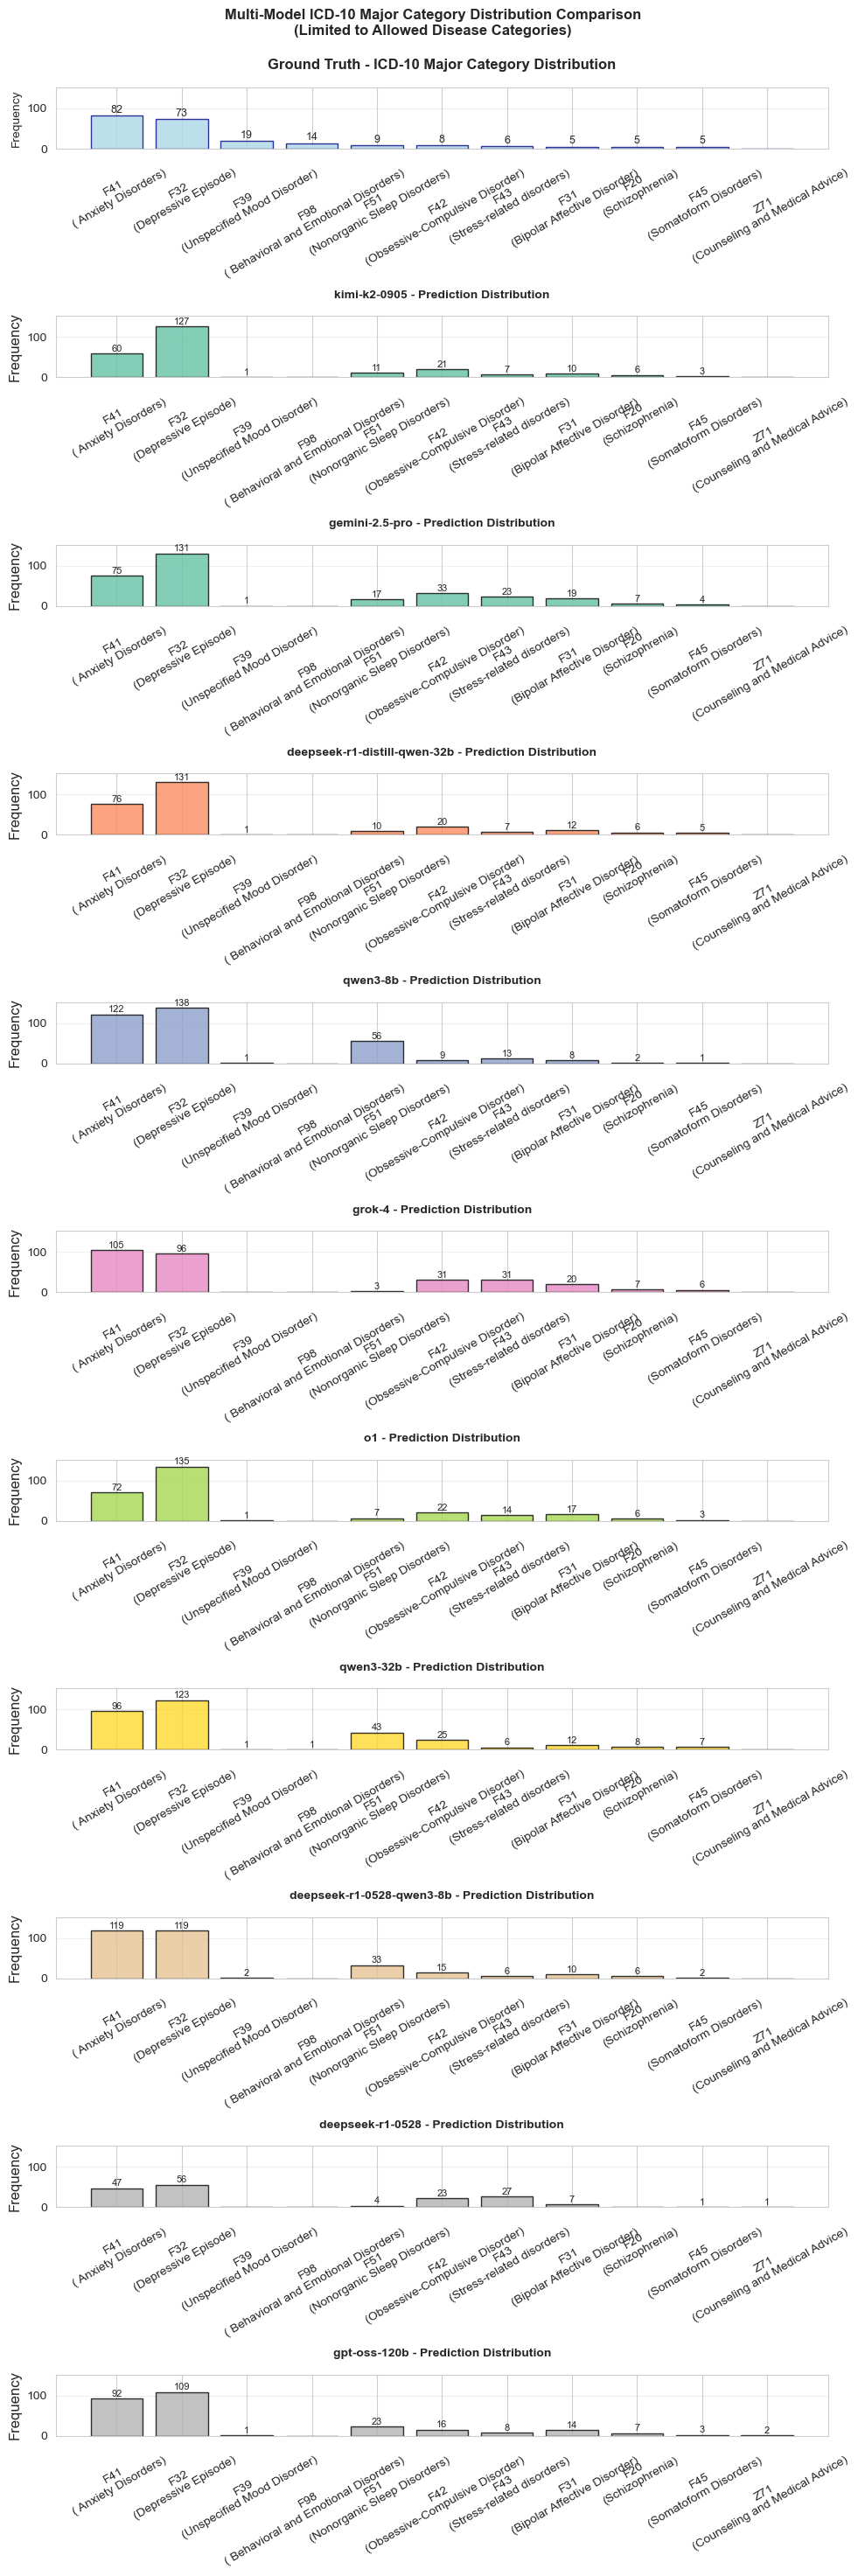

In [11]:
# 6. Multi-Model Major Category Label Distribution Comparison - Bar Chart (Limited to Allowed Diseases)

def plot_multi_model_major_comparison(gt_major_labels: List[List[str]], 
                                    model_major_predictions: Dict[str, List[List[str]]]) -> None:
    """Plot multi-model major category prediction comparison chart (limited to allowed diseases)"""
    
    # Flatten ground truth major category labels
    gt_major_flat = flatten_labels(gt_major_labels)
    gt_major_dist = dict(Counter(gt_major_flat))
    
    # Only consider allowed disease categories
    allowed_labels_in_gt = [label for label in gt_major_dist.keys() if label in ALLOWED_DISEASES]
    
    # Get all allowed diseases from model predictions
    all_allowed_labels = set(allowed_labels_in_gt)
    for pred_labels in model_major_predictions.values():
        pred_flat = flatten_labels(pred_labels)
        pred_allowed = [label for label in pred_flat if label in ALLOWED_DISEASES]
        all_allowed_labels.update(pred_allowed)
    
    # Sort by ground truth label frequency (only including allowed diseases)
    sorted_allowed_labels = sorted(all_allowed_labels, key=lambda x: gt_major_dist.get(x, 0), reverse=True)
    
    # Prepare ground truth data
    gt_labels = []
    gt_counts = []
    gt_disease_names = []
    
    for label in sorted_allowed_labels:
        disease_name = get_major_disease_name(label)
        gt_labels.append(label)
        gt_counts.append(gt_major_dist.get(label, 0))
        gt_disease_names.append(f"{label}\n({disease_name})")
    
    # Calculate number of models and create subplots
    num_models = len(model_major_predictions)
    fig, axes = plt.subplots(num_models + 1, 1, figsize=(10, 30))
    
    # If only one model, make axes a list for consistency
    if num_models == 0:
        axes = [axes]
    elif num_models == 1:
        axes = [axes[0], axes[1]]
    
    # Plot ground truth in the first subplot
    ax_gt = axes[0]
    bars_gt = ax_gt.bar(gt_disease_names, gt_counts, color='lightblue', alpha=0.8, edgecolor='navy', linewidth=1)
    ax_gt.set_title('Ground Truth - ICD-10 Major Category Distribution', fontsize=12, fontweight='bold', pad=15)
    ax_gt.set_ylabel('Frequency', fontsize=10)
    ax_gt.tick_params(axis='x', rotation=30, labelsize=10)
    ax_gt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on ground truth bars
    for bar in bars_gt:
        height = bar.get_height()
        if height > 0:
            ax_gt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                      f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Calculate max count for consistent y-axis scaling
    all_counts = gt_counts.copy()
    for pred_major_labels in model_major_predictions.values():
        pred_major_flat = flatten_labels(pred_major_labels)
        pred_major_dist = dict(Counter(pred_major_flat))
        pred_counts = [pred_major_dist.get(label, 0) for label in sorted_allowed_labels]
        all_counts.extend(pred_counts)
    
    max_overall = max(all_counts) if all_counts else 1
    
    # Plot each model in separate subplots
    colors = plt.cm.Set2(np.linspace(0, 1, num_models))
    
    for idx, (model_name, pred_major_labels) in enumerate(model_major_predictions.items()):
        ax = axes[idx + 1]
        
        # Calculate prediction distribution
        pred_major_flat = flatten_labels(pred_major_labels)
        pred_major_dist = dict(Counter(pred_major_flat))
        
        # Prepare prediction counts for this model
        pred_counts = []
        for label in sorted_allowed_labels:
            pred_counts.append(pred_major_dist.get(label, 0))
        
        # Plot bars for this model
        bars = ax.bar(gt_disease_names, pred_counts, color=colors[idx], alpha=0.8, 
                     edgecolor='black', linewidth=1)
        
        ax.set_title(f'{model_name} - Prediction Distribution', fontsize=10, fontweight='bold', pad=15)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.tick_params(axis='x', rotation=30, labelsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars (only show non-zero values)
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{int(height)}', ha='center', va='bottom', fontsize=8)
        
        # Set consistent y-axis limits
        ax.set_ylim(0, max_overall * 1.1)
    
    # Set consistent y-axis limits for ground truth
    ax_gt.set_ylim(0, max_overall * 1.1)
    
    # Add overall title
    fig.suptitle('Multi-Model ICD-10 Major Category Distribution Comparison\n(Limited to Allowed Disease Categories)', 
                 fontsize=12, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Plot multi-model major category comparison
if all_model_data and ground_truth_major_reference:
    print("📊 Plotting multi-model major category label distribution comparison...")
    
    # Prepare model major category prediction data
    model_major_predictions = {}
    for model_name, data in all_model_data.items():
        model_major_predictions[model_name] = data['predictions_major']
    
    plot_multi_model_major_comparison(ground_truth_major_reference, model_major_predictions)

else:
    print("❌ No available data for visualization")


In [13]:
# 7. Token长度分析函数

def calculate_token_length(text: str) -> int:
    """计算文本的token长度（使用字符数作为近似）"""
    if not text:
        return 0
    # 简单的token长度估算：中文字符按1个token计算，英文单词按空格分割计算
    # 这里使用字符数作为近似，实际应用中可以使用具体的tokenizer
    return len(text)

def extract_full_response_content(log_entry: dict) -> str:
    """从日志条目中提取完整的响应内容"""
    response = log_entry.get('response', {})
    if response is None:
        return ""
    
    content = response.get('content', '')
    if content is None:
        return ""
    
    return str(content)

def analyze_token_length_by_model(model_data: dict) -> dict:
    """分析单个模型的token长度分布"""
    token_lengths = []
    disease_token_lengths = defaultdict(list)  # 按疾病分组的token长度
    
    # 重新加载原始JSON数据以获取完整的response content
    json_file = model_data['file_path']
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    for i, log_entry in enumerate(data.get('logs', [])):
        # 提取完整的响应内容
        full_response = extract_full_response_content(log_entry)
        token_length = calculate_token_length(full_response)
        
        if token_length < 2:
            continue
        
        token_lengths.append(token_length)
        
        # 获取对应的真实标签（大类）
        if i < len(model_data['ground_truth_major']):
            gt_major_labels = model_data['ground_truth_major'][i]
            
            # 如果有多个疾病标签，将token长度添加到每个疾病类别中
            if gt_major_labels:
                for disease in gt_major_labels:
                    disease_token_lengths[disease].append(token_length)
            else:
                # 如果没有标签，归类为"无标签"
                disease_token_lengths['No_Label'].append(token_length)
    
    return {
        'all_token_lengths': token_lengths,
        'disease_token_lengths': dict(disease_token_lengths),
        'total_responses': len(token_lengths),
        'avg_token_length': np.mean(token_lengths) if token_lengths else 0,
        'median_token_length': np.median(token_lengths) if token_lengths else 0,
        'std_token_length': np.std(token_lengths) if token_lengths else 0,
        'min_token_length': min(token_lengths) if token_lengths else 0,
        'max_token_length': max(token_lengths) if token_lengths else 0
    }

print("✅ Token长度分析函数定义完成！")


✅ Token长度分析函数定义完成！


In [14]:
# 10.1 执行修改后的Token长度分析（去除失败样本）

print("📊 开始重新分析所有模型的token长度（去除失败样本）...")

# 存储修改后的所有模型的token长度分析结果
model_token_analysis_filtered = {}

for model_name, model_data in all_model_data.items():
    print(f"  重新分析 {model_name}...")
    try:
        analysis = analyze_token_length_by_model(model_data)
        model_token_analysis_filtered[model_name] = analysis
    except Exception as e:
        print(f"    ❌ 分析失败: {e}")

print(f"\n✅ 成功重新分析了 {len(model_token_analysis_filtered)} 个模型的token长度")



📊 开始重新分析所有模型的token长度（去除失败样本）...
  重新分析 kimi-k2-0905...
  重新分析 gemini-2.5-pro...
  重新分析 deepseek-r1-distill-qwen-32b...
  重新分析 qwen3-8b...
  重新分析 grok-4...
  重新分析 o1...
  重新分析 qwen3-32b...
  重新分析 deepseek-r1-0528-qwen3-8b...
  重新分析 deepseek-r1-0528...
  重新分析 gpt-oss-120b...

✅ 成功重新分析了 10 个模型的token长度


📊 开始绘制Token长度分布图...

1️⃣ 绘制整体Token长度分布图...


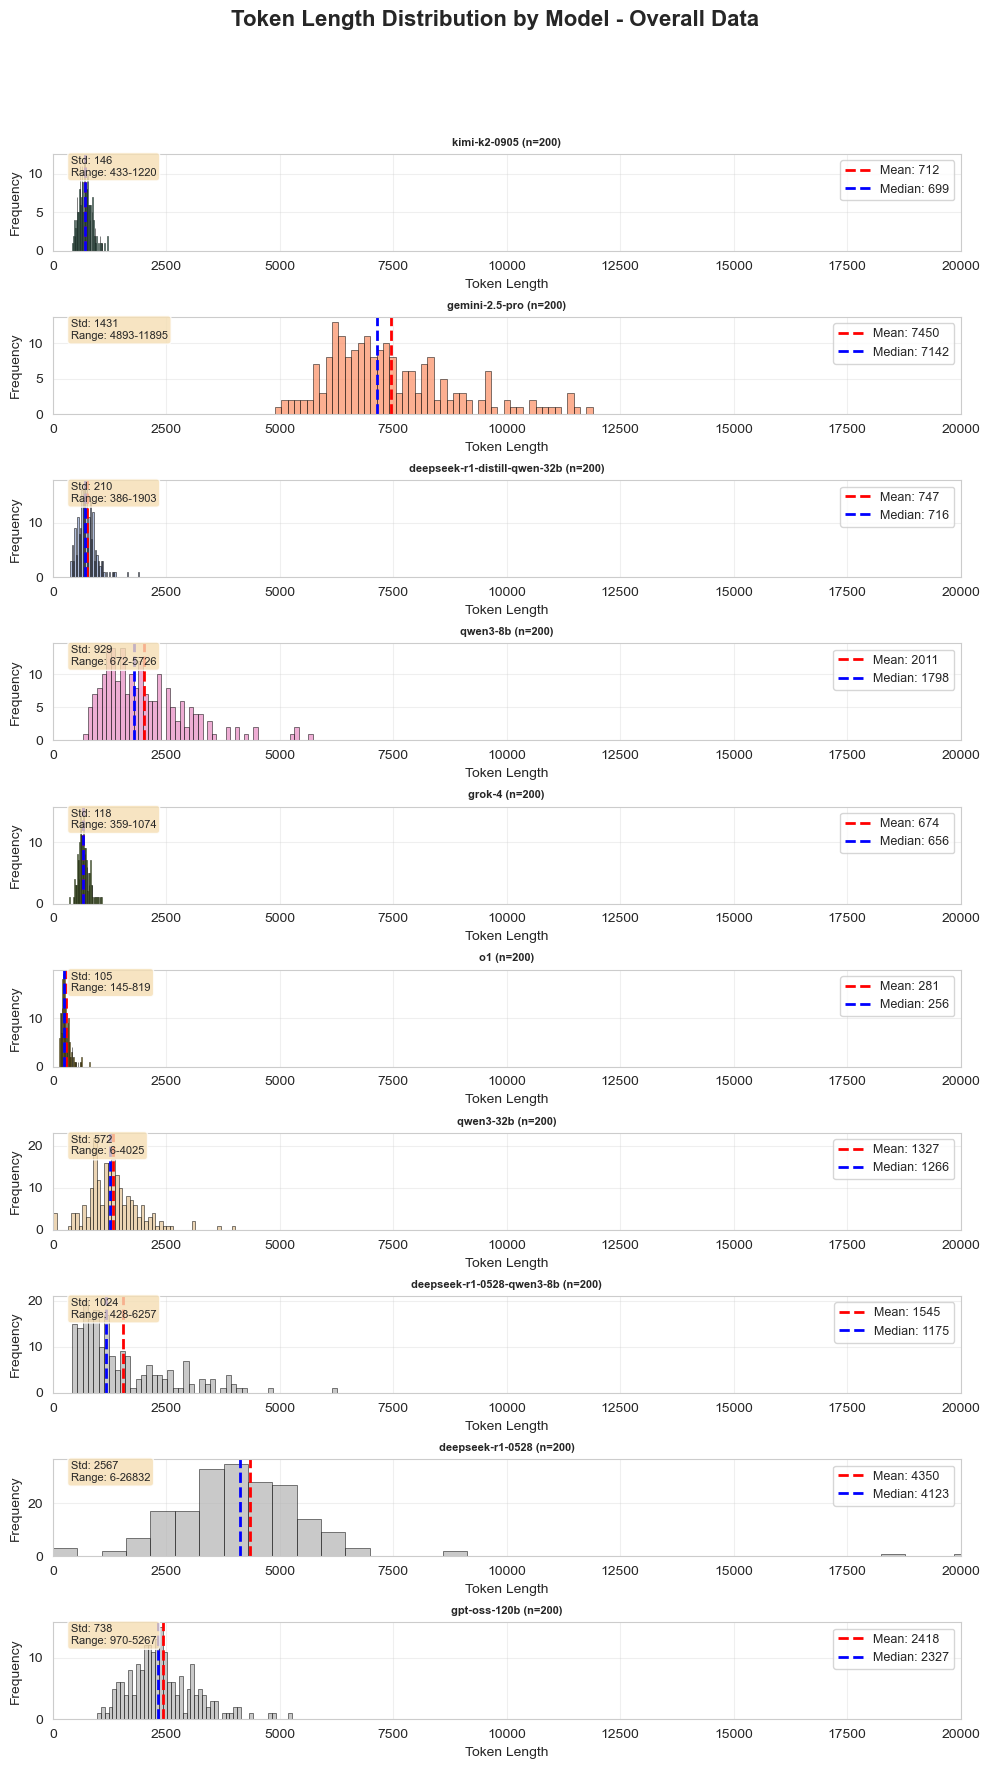


3️⃣ 绘制Token长度箱线图比较...


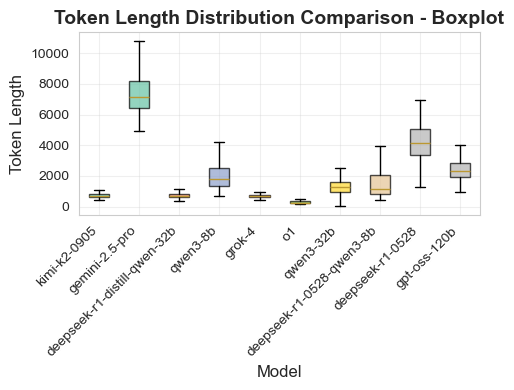


✅ 所有Token长度分布图绘制完成！


In [18]:
# 9. Token Length Distribution Visualization

def plot_token_length_distribution_overall(model_token_analysis: dict) -> None:
    """Plot overall token length distribution for all models"""
    
    # Create subplots
    fig, axes = plt.subplots(len(model_token_analysis), 1, figsize=(10, 18))
    axes = axes.flatten()
    
    # Plot distribution for each model
    for idx, (model_name, analysis) in enumerate(model_token_analysis.items()):
        ax = axes[idx]
        token_lengths = analysis['all_token_lengths']
        
        # Plot histogram
        ax.hist(token_lengths, bins=50, alpha=0.7, color=plt.cm.Set2(idx), edgecolor='black', linewidth=0.5)
        
        # Add statistical lines
        mean_val = analysis['avg_token_length']
        median_val = analysis['median_token_length']
        
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.0f}')
        ax.axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_val:.0f}')
        
        # Set title and labels
        ax.set_title(f'{model_name} (n={analysis["total_responses"]})', fontsize=8, fontweight='bold')
        ax.set_xlabel('Token Length', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.legend(fontsize=9)
        ax.set_xlim(0, 20000)
        ax.grid(True, alpha=0.3)
        
        # Add stats text
        stats_text = f'Std: {analysis["std_token_length"]:.0f}\nRange: {analysis["min_token_length"]}-{analysis["max_token_length"]}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=8, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Hide extra subplots
    for idx in range(len(model_token_analysis), len(axes)):
        axes[idx].set_visible(False)
    
    # Set overall title
    fig.suptitle('Token Length Distribution by Model - Overall Data', fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

def plot_token_length_by_disease(model_token_analysis: dict) -> None:
    """Plot token length distribution grouped by disease"""
    
    # Collect all disease categories (exclude those with too few samples)
    all_diseases = set()
    for analysis in model_token_analysis.values():
        for disease, lengths in analysis['disease_token_lengths'].items():
            if len(lengths) >= 5:  # Only include diseases with >=5 samples
                all_diseases.add(disease)
    
    # Sort diseases by sample count (using first model as reference)
    first_model_analysis = list(model_token_analysis.values())[0]
    disease_sample_counts = {}
    for disease in all_diseases:
        if disease in first_model_analysis['disease_token_lengths']:
            disease_sample_counts[disease] = len(first_model_analysis['disease_token_lengths'][disease])
        else:
            disease_sample_counts[disease] = 0
    
    sorted_diseases = sorted(all_diseases, key=lambda x: disease_sample_counts.get(x, 0), reverse=True)
    
    # Create subplots for each disease
    num_diseases = len(sorted_diseases)
    cols = 3
    rows = (num_diseases + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
    if rows == 1:
        axes = [axes] if num_diseases == 1 else axes
    else:
        axes = axes.flatten()
    
    for disease_idx, disease in enumerate(sorted_diseases):
        ax = axes[disease_idx]
        
        # Plot distribution for each model within the same disease
        colors = plt.cm.Set2(np.linspace(0, 1, len(model_token_analysis)))
        
        for model_idx, (model_name, analysis) in enumerate(model_token_analysis.items()):
            if disease in analysis['disease_token_lengths']:
                token_lengths = analysis['disease_token_lengths'][disease]
                if len(token_lengths) >= 5:  # Only plot if samples >= 5
                    ax.hist(token_lengths, bins=20, alpha=0.6, 
                           color=colors[model_idx], label=f'{model_name} (n={len(token_lengths)})',
                           edgecolor='black', linewidth=0.3)
        
        # Set title and labels
        disease_name = get_major_disease_name(disease) if disease != 'No_Label' else 'No Label'
        ax.set_title(f'{disease} - {disease_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Token Length', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplots
    for idx in range(num_diseases, len(axes)):
        axes[idx].set_visible(False)
    
    # Set overall title
    fig.suptitle('Token Length Distribution by Model - Grouped by Disease', fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

def plot_token_length_boxplot_comparison(model_token_analysis: dict) -> None:
    """Plot boxplot comparison of token lengths between models"""
    
    # Prepare data
    model_names = list(model_token_analysis.keys())
    token_data = [analysis['all_token_lengths'] for analysis in model_token_analysis.values()]
    
    # Create single plot
    fig, ax = plt.subplots(figsize=(5, 4))
    
    # Overall boxplot
    bp = ax.boxplot(token_data, labels=model_names, patch_artist=True, 
                    showfliers=False)
    
    # Set colors
    colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title('Token Length Distribution Comparison - Boxplot', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Token Length', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    plt.setp(ax.get_xticklabels(), ha='right')
    
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 10. 执行Token长度分布可视化

print("📊 开始绘制Token长度分布图...")

if model_token_analysis_filtered:
    print("\n1️⃣ 绘制整体Token长度分布图...")
    plot_token_length_distribution_overall(model_token_analysis_filtered)
    
    print("\n3️⃣ 绘制Token长度箱线图比较...")
    plot_token_length_boxplot_comparison(model_token_analysis_filtered)
    
    print("\n✅ 所有Token长度分布图绘制完成！")
else:
    print("❌ 没有可用的token长度分析数据")
